#  Simple tool to analyze data from https://data.europa.eu/

The EU Open Data Portal (EU ODP) aims to encourage the use of EU datasets for building third-party applications.

**Note:** This is a Jupyter notebook which is also available as its executable export as a Python 3 script (therefore with automatically generated comments).

# Libraries

In [1]:
# Sys import
import sys, os, re
# Common imports
import math
import numpy             as NP
import numpy.random      as RAND
import scipy.stats       as STATS
from scipy import sparse
from scipy import linalg

# Better formatting functions
from IPython.display import display, HTML
from IPython import get_ipython

import matplotlib        as MPL
import matplotlib.pyplot as PLT
import seaborn as SNS
SNS.set(font_scale=1)

# Python programming
from itertools import cycle
from time import time
import datetime

# Using pandas
import pandas as PAN
import xlrd
import numpy as NP

In [2]:
import warnings
warnings.filterwarnings('ignore')
print("For now, reduce python warnings, I will look into this later")

For now, reduce python warnings, I will look into this later


### Import my own modules
The next cell attempts to give user some information if things improperly setup.
Intended to work both in Jupyter and when executing the Python file directly.

In [3]:
if not get_ipython() is None and os.path.abspath("../source/") not in sys.path:
    sys.path.append(os.path.abspath("../source/"))
try:
    from lib.utilities     import *
    from lib.figureHelpers import *
    from lib.DataMgrRdf        import *
    import lib.basicDataCTE as DCTE
except Exception as err:
    print("Could not find library 'lib' with contents 'DataGouvFr' ")
    if get_ipython() is None:
        print("Check the PYTHONPATH environment variable which should point to 'source' wich contains 'lib'")
    else:
        print("You are supposed to be running in JupySessions, and '../source/lib' should exist")
    raise err

Loaded lib
For now, reduce python warnings, I will look into this later


## Check environment

It is expected that:
- your working directory is named `JupySessions`, 
- that it has subdirectories 
   - `images/*` where generated images may be stored to avoid overcrowding. 
- At the same level as your working dir there should be directories 
   - `../data` for storing input data and 
   - `../source` for python scripts.
   
My package library is in `../source/lib`, and users running under Python (not in Jupyter) should
set their PYTHONPATH to include "../source" ( *or whatever appropriate* ).

In [4]:
checkSetup(chap="Chap03")
ImgMgr = ImageMgr(chapdir="Chap03")

# Load Data

## Functions

## Load CSV and XLSX data from remote 
The `dataFileVMgr` will manage a cache of data files in `../dataEURdf`, the data will be downloaded
from  https://data.europa.eu using the SPARQL query endpoint. The meta information is stored/cached  in `../dataEURdf/.cache*`

We check what is in the cache/data directory; for each file, we identify the latest version, 
and list this below to make sure. The file name will usually contain a time stamp.

<FONT COLOR="RED">TO BE CHECKED For the files used in this notebook, the latest version is used/loaded irrespective of the
timestamp used in the notebook.</FONT>

In [5]:
dataFileVMgr = manageAndCacheDataFilesRdfEU( "../dataEURdf")
dataFileVMgr.getRemoteInfo()

Need to reload cache from remote,  stale after 26h 5m 10s
In <class 'lib.DataMgrRdf.manageAndCacheDataFilesRdfEU'>._buildRemoteSparql	 available options:
	['ApiHeaders', 'ApiInq', 'CacheValidity', 'HttpHDR', 'HttpRQT', 'cacheFname', 'httpTimeOut', 'maxDirSz', 'maxImportSz', 'showMetaData']
HTTP response headers:{'Date': 'Mon, 08 Jun 2020 21:44:57 GMT', 'Content-Type': 'application/rdf+xml; charset=UTF-8', 'Access-Control-Allow-Origin': '*', 'Server': 'Europa', 'Connection': 'close', 'Content-Encoding': 'gzip'}
HTTP request:<PreparedRequest [POST]>
HTTP request headers:{'User-Agent': 'python-requests/2.23.0', 'Accept-Encoding': 'gzip, deflate', 'Accept': 'application/rdf+xml', 'Connection': 'keep-alive', 'Content-Type': 'application/rdf+xml', 'Content-Length': '0'}
URL/request=https://data.europa.eu/euodp//sparqlep?query=%0APREFIX+http%3A+%3Chttp%3A%2F%2Fwww.w3.org%2F2011%2Fhttp%23%3E%0APREFIX+dcat%3A+%3Chttp%3A%2F%2Fwww.w3.org%2Fns%2Fdcat%23%3E%0APREFIX+odp%3A++%3Chttp%3A%2F%2Fdata.eur

Wrote generated rdf (xml) on ../dataEURdf/.cache.prdf


This can be long, the SPARQL processor used is not fast

In [6]:
dataFileVMgr.updatePrepare()
dataFileVMgr.cacheUpdate()

qn='ns1:DAILY'	mod=None
About to load file ../dataEURdf/covid-19-coronavirus-data.csv, available space is 48992236
Wrote file 	'../dataEURdf/covid-19-coronavirus-data.csv'
	from URL:'https://opendata.ecdc.europa.eu/covid19/casedistribution/csv'


## Get some understanding of the available resource

In [7]:
nbLastDays = 30

## Dig into the data

In [8]:
print("Most recent versions of files in data directory:")
for f in dataFileVMgr.listMostRecent(nonTS=True) :
    print(f"\t{f}")

Most recent versions of files in data directory:
	.cache.prdf
	.cache.qhash
	.cache.rdf
	covid-19-coronavirus-data.csv


In [9]:
last = lambda x: dataFileVMgr.getRecentVersion(x,default=os.path.join(dataFileVMgr.dirpath,x))

In [10]:
dataFileVMgr.nonTSFiles

{'.cache.rdf': None,
 'covid-19-coronavirus-data.csv': None,
 '.cache.prdf': None,
 '.cache.qhash': None}

In [11]:
covidDataEUCsv = last("covid-19-coronavirus-data.csv")
data_covidDataEU  = read_csvPandas(covidDataEUCsv , error_bad_lines=False,sep="," )

In [12]:
data_covidDataEU.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22174 entries, 0 to 22173
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   dateRep                  22174 non-null  object 
 1   day                      22174 non-null  int64  
 2   month                    22174 non-null  int64  
 3   year                     22174 non-null  int64  
 4   cases                    22174 non-null  int64  
 5   deaths                   22174 non-null  int64  
 6   countriesAndTerritories  22174 non-null  object 
 7   geoId                    22088 non-null  object 
 8   countryterritoryCode     21858 non-null  object 
 9   popData2018              21843 non-null  float64
 10  continentExp             22174 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 1.9+ MB


In [13]:
data_covidDataEU[:3]

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
0,08/06/2020,8,6,2020,791,30,Afghanistan,AF,AFG,37172386.0,Asia
1,07/06/2020,7,6,2020,582,18,Afghanistan,AF,AFG,37172386.0,Asia
2,06/06/2020,6,6,2020,915,9,Afghanistan,AF,AFG,37172386.0,Asia


In [14]:
def sortedIds(df,col):
   t=df.loc[:,col].unique()
   return sorted([ x  for x in t if isinstance(x, str) ])

This seems necessary, since there were NaNs in the "geoId" column

In [15]:
for coln in ("geoId" , "countryterritoryCode", "countriesAndTerritories"):
    si = sortedIds(data_covidDataEU, coln)
    print(f"{coln:30}-> {len(si)} elts")

geoId                         -> 209 elts
countryterritoryCode          -> 205 elts
countriesAndTerritories       -> 210 elts


In [16]:
data_covidDataEU["date"] = PAN.to_datetime(data_covidDataEU.loc[:,"dateRep"], format="%d/%m/%Y")

In [17]:
dateStart = data_covidDataEU["date"].min()
dateEnd   = data_covidDataEU["date"].max() 
dateSpan  = dateEnd - dateStart 
print(f"Our statistics span {dateSpan.days+1} days, start: {dateStart} and end {dateEnd}")

data_covidDataEU["elapsedDays"] = (data_covidDataEU["date"] - dateStart).dt.days

Our statistics span 161 days, start: 2019-12-31 00:00:00 and end 2020-06-08 00:00:00


In [18]:
data_covidDataEU["elapsedDays"][:3] 

0    160
1    159
2    158
Name: elapsedDays, dtype: int64

In [19]:
dt  = data_covidDataEU.copy()
dt = dt.set_index("continentExp")

In [20]:
dtx = dt[dt.index == "Europe"]
dtg = dtx.groupby("countriesAndTerritories")

In [21]:
for (country,dfExtract) in dtg:
    print(f"{country:30}\t-> data over {dfExtract.shape[0]} days")

Albania                       	-> data over 92 days
Andorra                       	-> data over 87 days
Armenia                       	-> data over 152 days
Austria                       	-> data over 161 days
Azerbaijan                    	-> data over 154 days
Belarus                       	-> data over 153 days
Belgium                       	-> data over 161 days
Bosnia_and_Herzegovina        	-> data over 88 days
Bulgaria                      	-> data over 91 days
Croatia                       	-> data over 158 days
Cyprus                        	-> data over 89 days
Czechia                       	-> data over 161 days
Denmark                       	-> data over 161 days
Estonia                       	-> data over 156 days
Faroe_Islands                 	-> data over 81 days
Finland                       	-> data over 157 days
France                        	-> data over 161 days
Georgia                       	-> data over 158 days
Germany                       	-> data over 161 days

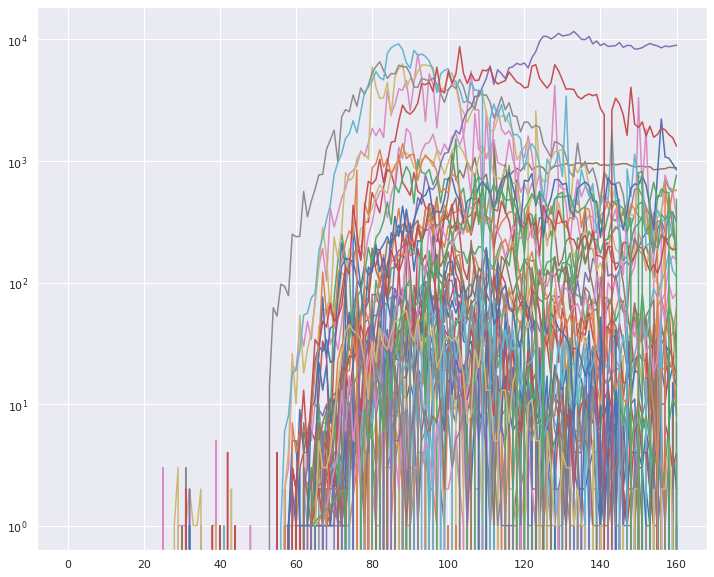

In [22]:
for (country,dfExtract) in dtg :
       #print(f"{country:30}\t-> data over {dfExtract.shape[0]} days")
       PLT.plot( dfExtract.loc[:,["elapsedDays"]], dfExtract.loc[:,["cases"]])
       PLT.yscale("log")
       #painter = figureTSFromFrame(dfExtract.loc[:,["cases","deaths"]],figsize=(12,8))
       #painter.doPlot()

In [23]:
dtx = dt[ (dt.index == "Europe") & (dt["popData2018"] > 10.0e6) ]
dtg = dtx.groupby("countriesAndTerritories")
subnodeSpec=(lambda i,j:{"nrows":i,"ncols":j})(*subPlotShape(len(dtg),maxCol=4))

Country=Belgium, pop:11.422068M
Country=Czechia, pop:10.625695M
Country=France, pop:66.987244M
Country=Germany, pop:82.927922M
Country=Greece, pop:10.727668M
Country=Italy, pop:60.431283M
Country=Netherlands, pop:17.231017M
Country=Poland, pop:37.978548M
Country=Portugal, pop:10.281762M
Country=Romania, pop:19.473936M
Country=Russia, pop:144.47805M
Country=Spain, pop:46.723749M
Country=Sweden, pop:10.183175M
Country=Ukraine, pop:44.622516M
Country=United_Kingdom, pop:66.488991M
Saving figure FIG007


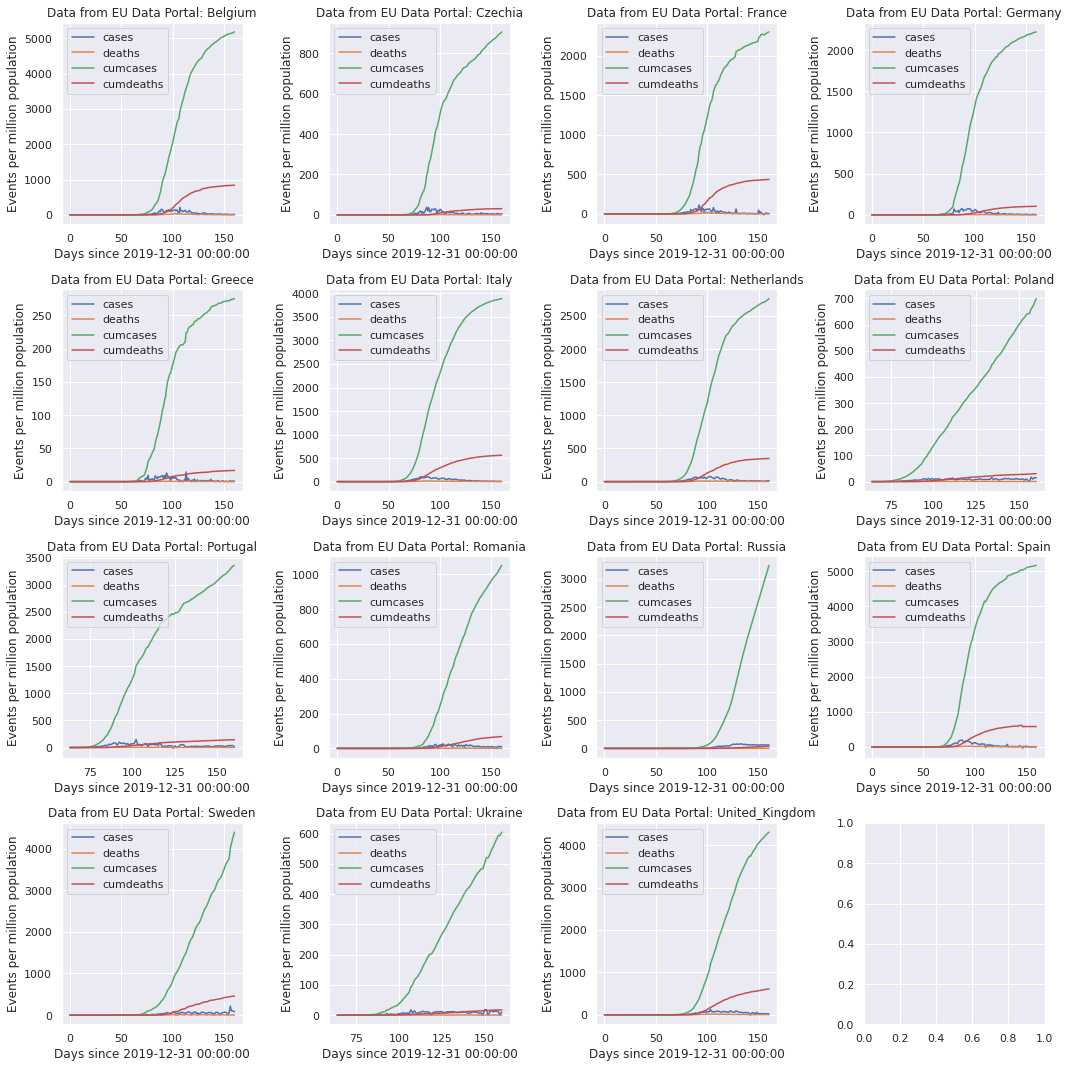

In [24]:
painter = figureFromFrame(None, subplots=subnodeSpec, figsize=(15,15))
for (country,dfExtractOrig) in dtg :
    pop = dfExtractOrig["popData2018"][0]
    print(f"Country={country}, pop:{pop/1.0E6}M")
    dfExtract = dfExtractOrig.set_index("elapsedDays").copy()
    dfExtract.loc[:,"cumcases"] = dfExtract.loc[:,"cases"].sort_index().cumsum()/dfExtract.loc[:,"popData2018"]*1.0E6
    dfExtract.loc[:,"cumdeaths"] = dfExtract.loc[:,"deaths"].sort_index().cumsum()/dfExtract.loc[:,"popData2018"]*1.0E6
    dfExtract.loc[:,"cases"] = dfExtract.loc[:,"cases"]/dfExtract.loc[:,"popData2018"]*1.0E6
    dfExtract.loc[:,"deaths"] = dfExtract.loc[:,"deaths"]/dfExtract.loc[:,"popData2018"]*1.0E6
    painter.doPlot(df = dfExtract.loc[:,["cases","deaths","cumcases","cumdeaths"]])
    painter.setAttrs(label=f"Days since {dateStart}",
                 title=f"Data from EU Data Portal: {country}",
                 legend=True,
                 xlabel=f"Days since {dateStart}",
                 ylabel="Events per million population"   )
        
    painter.advancePlotIndex()  
ImgMgr.save_fig("FIG007")  

Country=Belgium, pop:11.422068M
Country=Czechia, pop:10.625695M
Country=France, pop:66.987244M
Country=Germany, pop:82.927922M
Country=Greece, pop:10.727668M
Country=Italy, pop:60.431283M
Country=Netherlands, pop:17.231017M
Country=Poland, pop:37.978548M
Country=Portugal, pop:10.281762M
Country=Romania, pop:19.473936M
Country=Russia, pop:144.47805M
Country=Spain, pop:46.723749M
Country=Sweden, pop:10.183175M
Country=Ukraine, pop:44.622516M
Country=United_Kingdom, pop:66.488991M
Saving figure FIG017


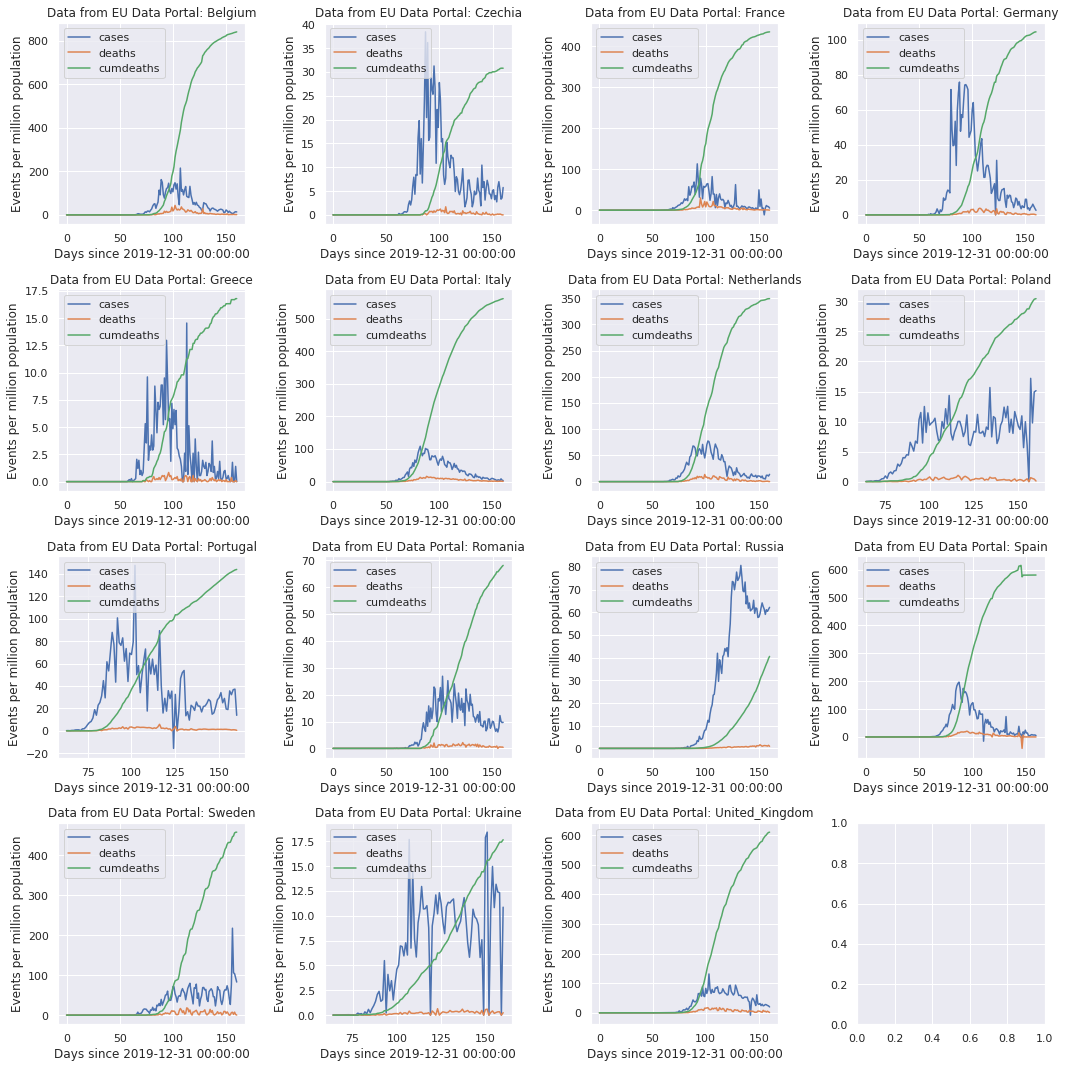

In [25]:
painter = figureFromFrame(None, subplots=subnodeSpec, figsize=(15,15))
for (country,dfExtractOrig) in dtg :
    pop = dfExtractOrig["popData2018"][0]
    print(f"Country={country}, pop:{pop/1.0E6}M")
    dfExtract = dfExtractOrig.set_index("elapsedDays").copy()
    dfExtract.loc[:,"cumdeaths"] = dfExtract.loc[:,"deaths"].sort_index().cumsum()/dfExtract.loc[:,"popData2018"]*1.0E6
    dfExtract.loc[:,"cases"] = dfExtract.loc[:,"cases"]/dfExtract.loc[:,"popData2018"]*1.0E6
    dfExtract.loc[:,"deaths"] = dfExtract.loc[:,"deaths"]/dfExtract.loc[:,"popData2018"]*1.0E6
    painter.doPlot(df = dfExtract.loc[:,["cases","deaths","cumdeaths"]])
    painter.setAttrs(label=f"Days since {dateStart}",
                 title=f"Data from EU Data Portal: {country}",
                 legend=True,
                 xlabel=f"Days since {dateStart}",
                 ylabel="Events per million population"   )
        
    painter.advancePlotIndex()  
ImgMgr.save_fig("FIG017")  

Country=Belgium, pop:11.422068M
Country=Czechia, pop:10.625695M
Country=France, pop:66.987244M
Country=Germany, pop:82.927922M
Country=Greece, pop:10.727668M
Country=Italy, pop:60.431283M
Country=Netherlands, pop:17.231017M
Country=Poland, pop:37.978548M
Country=Portugal, pop:10.281762M
Country=Romania, pop:19.473936M
Country=Russia, pop:144.47805M
Country=Spain, pop:46.723749M
Country=Sweden, pop:10.183175M
Country=Ukraine, pop:44.622516M
Country=United_Kingdom, pop:66.488991M
Saving figure FIG008


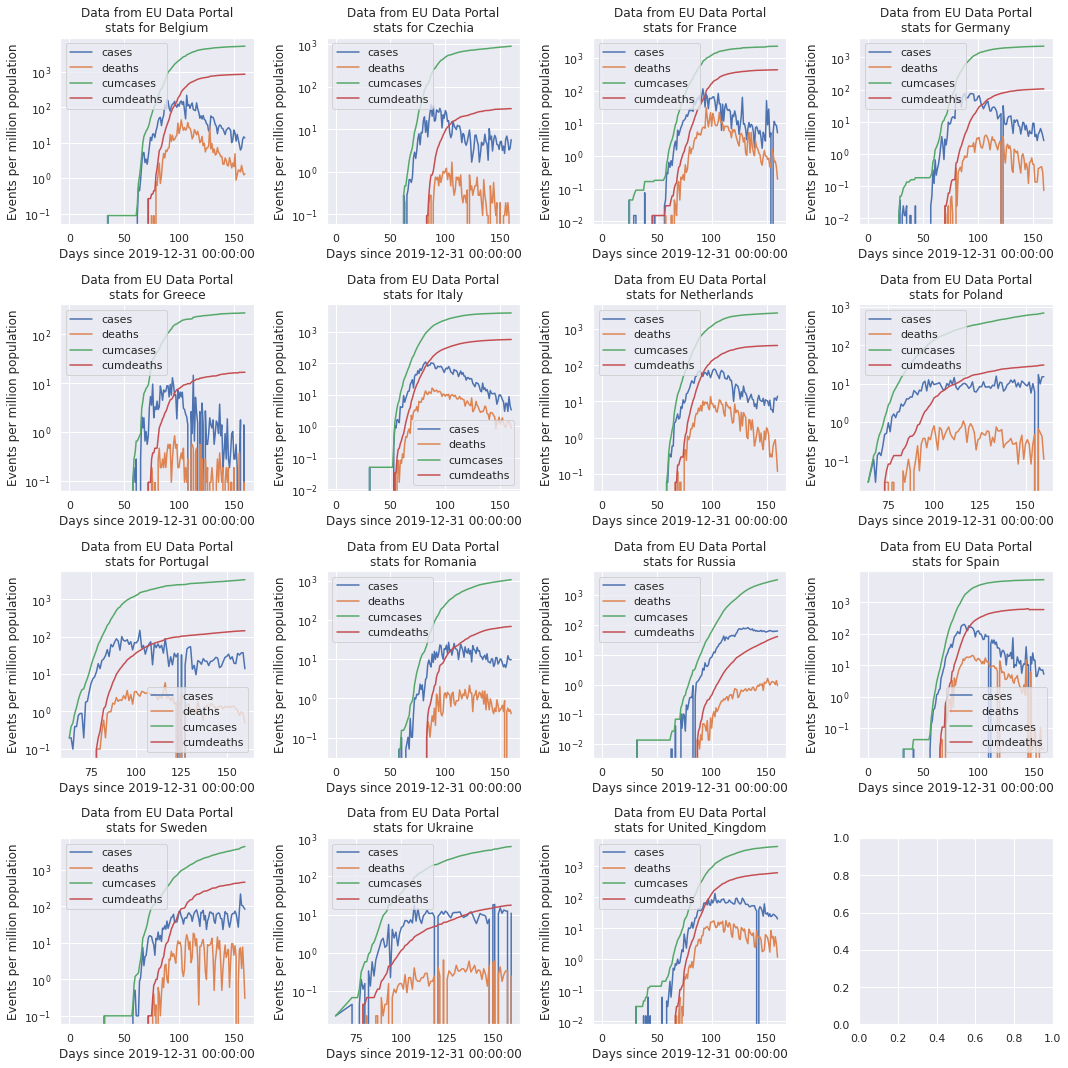

In [26]:
painter = figureFromFrame(None,  subplots=subnodeSpec, figsize=(15,15))
for (country,dfExtractOrig) in dtg :
    pop = dfExtractOrig["popData2018"][0]
    print(f"Country={country}, pop:{pop/1.0E6}M")
    dfExtract = dfExtractOrig.set_index("elapsedDays").copy()
    dfExtract.loc[:,"cumcases"] = dfExtract.loc[:,"cases"].sort_index().cumsum()/dfExtract.loc[:,"popData2018"]*1.0E6
    dfExtract.loc[:,"cumdeaths"] = dfExtract.loc[:,"deaths"].sort_index().cumsum()/dfExtract.loc[:,"popData2018"]*1.0E6
    dfExtract.loc[:,"cases"] = dfExtract.loc[:,"cases"]/dfExtract.loc[:,"popData2018"]*1.0E6
    dfExtract.loc[:,"deaths"] = dfExtract.loc[:,"deaths"]/dfExtract.loc[:,"popData2018"]*1.0E6
    painter.doPlot( df = dfExtract.loc[:,["cases","deaths","cumcases","cumdeaths"]],
                      colOpts={"cases": {"yscale":'log'},
                            "deaths": {"yscale":'log'},
                            "cumcases": {"yscale":'log'},
                            "cumdeaths": {"yscale":'log'},})
    painter.setAttrs(label=f"Days since {dateStart}",
                 title=f"Data from EU Data Portal\nstats for {country}",
                 legend=True,
                 xlabel=f"Days since {dateStart}",
                 ylabel="Events per million population"   )
    painter.advancePlotIndex()
ImgMgr.save_fig("FIG008")        

### Look at the largest countries

In [27]:
dtx = dt[ dt["popData2018"] > 65.0e6 ]
dtg = dtx.groupby("countriesAndTerritories")
subnodeSpec=(lambda i,j:{"nrows":i,"ncols":j})(*subPlotShape(len(dtg),maxCol=4, colFirst=False))

Country=Bangladesh, pop:161.356039M
Country=Brazil, pop:209.469333M
Country=China, pop:1392.73M
Country=Democratic_Republic_of_the_Congo, pop:84.068091M
Country=Egypt, pop:98.423595M
Country=Ethiopia, pop:109.224559M
Country=France, pop:66.987244M
Country=Germany, pop:82.927922M
Country=India, pop:1352.617328M
Country=Indonesia, pop:267.663435M
Country=Iran, pop:81.800269M
Country=Japan, pop:126.5291M
Country=Mexico, pop:126.190788M
Country=Nigeria, pop:195.87474M
Country=Pakistan, pop:212.21503M
Country=Philippines, pop:106.651922M
Country=Russia, pop:144.47805M
Country=Thailand, pop:69.428524M
Country=Turkey, pop:82.319724M
Country=United_Kingdom, pop:66.488991M
Country=United_States_of_America, pop:327.167434M
Country=Vietnam, pop:95.540395M
Saving figure FIG009


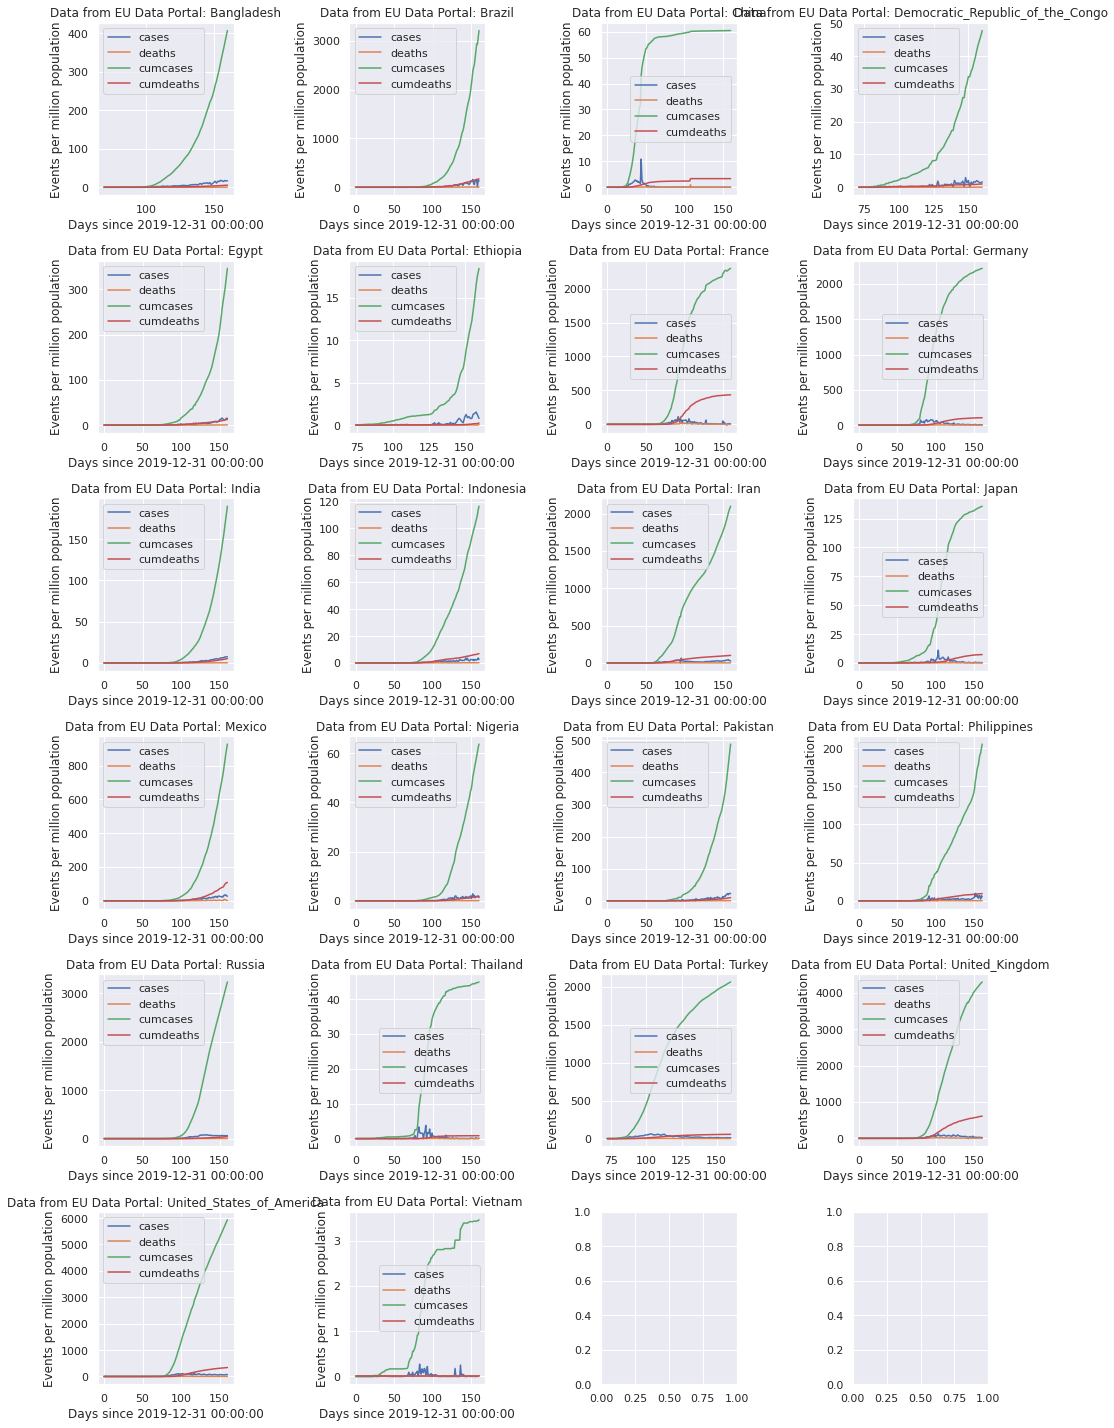

In [28]:
painter = figureFromFrame(None, subplots=subnodeSpec, figsize=(15,20))
for (country,dfExtractOrig) in dtg :
    pop = dfExtractOrig["popData2018"][0]
    print(f"Country={country}, pop:{pop/1.0E6}M")
    dfExtract = dfExtractOrig.set_index("elapsedDays").copy()
    dfExtract.loc[:,"cumcases"] = dfExtract.loc[:,"cases"].sort_index().cumsum()/dfExtract.loc[:,"popData2018"]*1.0E6
    dfExtract.loc[:,"cumdeaths"] = dfExtract.loc[:,"deaths"].sort_index().cumsum()/dfExtract.loc[:,"popData2018"]*1.0E6
    dfExtract.loc[:,"cases"] = dfExtract.loc[:,"cases"]/dfExtract.loc[:,"popData2018"]*1.0E6
    dfExtract.loc[:,"deaths"] = dfExtract.loc[:,"deaths"]/dfExtract.loc[:,"popData2018"]*1.0E6
    painter.doPlot(df = dfExtract.loc[:,["cases","deaths","cumcases","cumdeaths"]])
    painter.setAttrs(label=f"Days since {dateStart}",
                 title=f"Data from EU Data Portal: {country}",
                 legend=True,
                 xlabel=f"Days since {dateStart}",
                 ylabel="Events per million population"   )
        
    painter.advancePlotIndex()  
ImgMgr.save_fig("FIG009")  

Country=Bangladesh, pop:161.356039M
Country=Brazil, pop:209.469333M
Country=China, pop:1392.73M
Country=Democratic_Republic_of_the_Congo, pop:84.068091M
Country=Egypt, pop:98.423595M
Country=Ethiopia, pop:109.224559M
Country=France, pop:66.987244M
Country=Germany, pop:82.927922M
Country=India, pop:1352.617328M
Country=Indonesia, pop:267.663435M
Country=Iran, pop:81.800269M
Country=Japan, pop:126.5291M
Country=Mexico, pop:126.190788M
Country=Nigeria, pop:195.87474M
Country=Pakistan, pop:212.21503M
Country=Philippines, pop:106.651922M
Country=Russia, pop:144.47805M
Country=Thailand, pop:69.428524M
Country=Turkey, pop:82.319724M
Country=United_Kingdom, pop:66.488991M
Country=United_States_of_America, pop:327.167434M
Country=Vietnam, pop:95.540395M
Saving figure FIG019


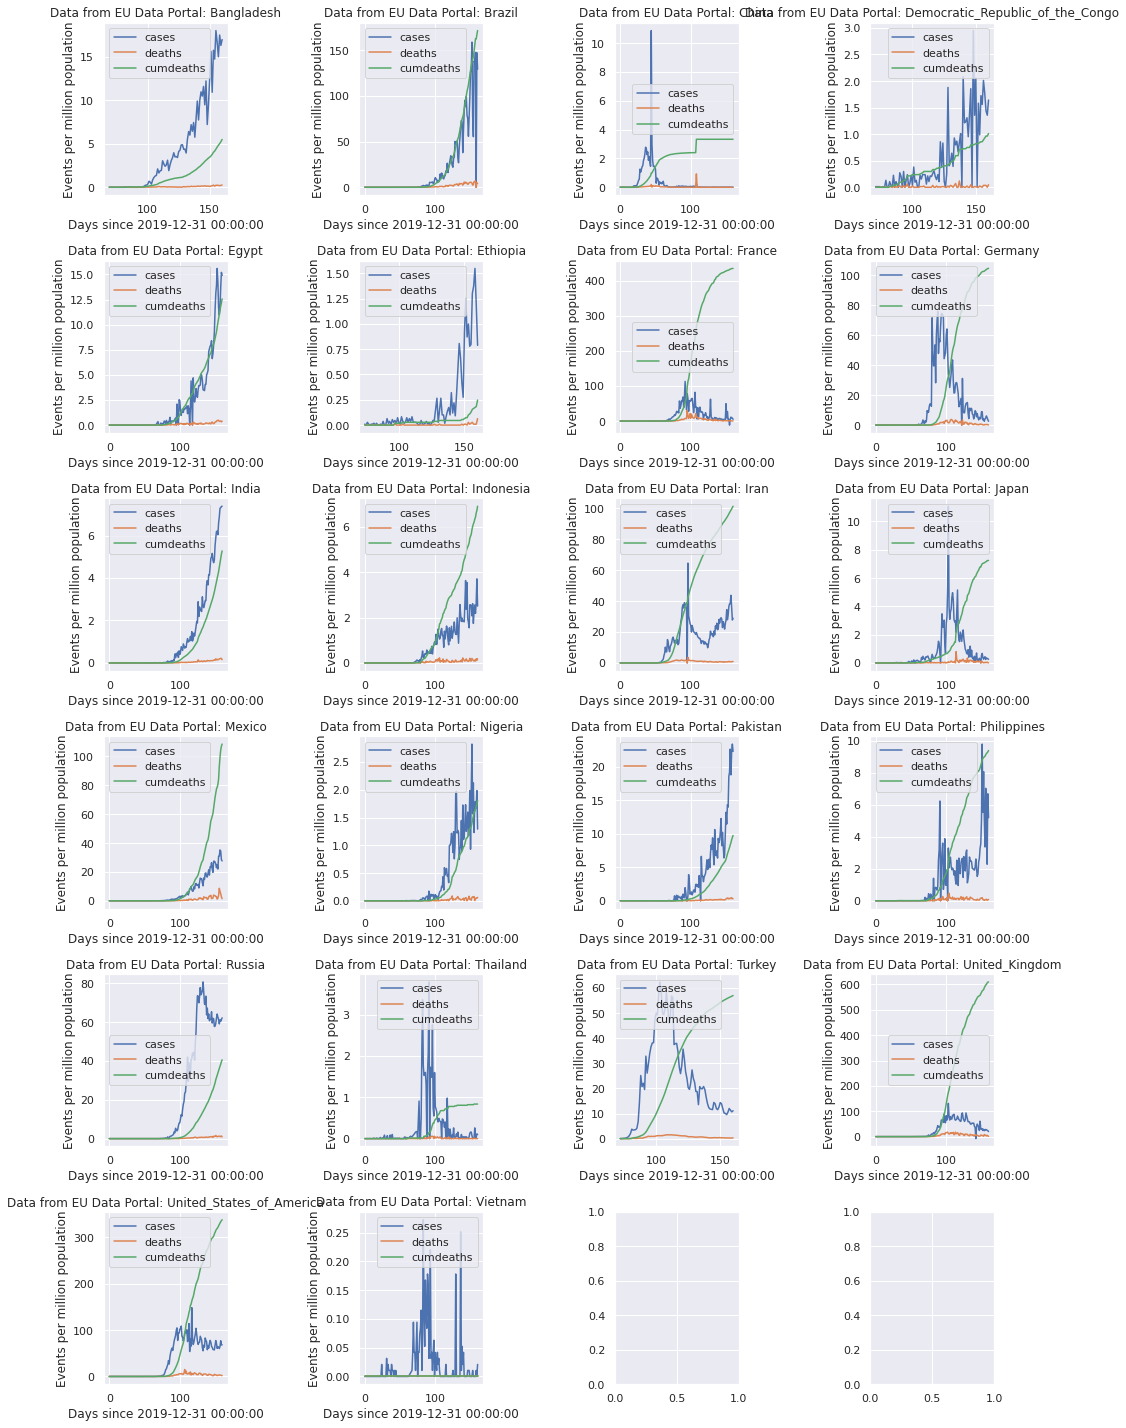

In [29]:
painter = figureFromFrame(None, subplots=subnodeSpec, figsize=(15,20))
for (country,dfExtractOrig) in dtg :
    pop = dfExtractOrig["popData2018"][0]
    print(f"Country={country}, pop:{pop/1.0E6}M")
    dfExtract = dfExtractOrig.set_index("elapsedDays").copy()
    dfExtract.loc[:,"cumdeaths"] = dfExtract.loc[:,"deaths"].sort_index().cumsum()/dfExtract.loc[:,"popData2018"]*1.0E6
    dfExtract.loc[:,"cases"] = dfExtract.loc[:,"cases"]/dfExtract.loc[:,"popData2018"]*1.0E6
    dfExtract.loc[:,"deaths"] = dfExtract.loc[:,"deaths"]/dfExtract.loc[:,"popData2018"]*1.0E6
    painter.doPlot(df = dfExtract.loc[:,["cases","deaths","cumdeaths"]])
    painter.setAttrs(label=f"Days since {dateStart}",
                 title=f"Data from EU Data Portal: {country}",
                 legend=True,
                 xlabel=f"Days since {dateStart}",
                 ylabel="Events per million population"   )
        
    painter.advancePlotIndex()  
ImgMgr.save_fig("FIG019")  

Country=Bangladesh, pop:161.356039M
Country=Brazil, pop:209.469333M
Country=China, pop:1392.73M
Country=Democratic_Republic_of_the_Congo, pop:84.068091M
Country=Egypt, pop:98.423595M
Country=Ethiopia, pop:109.224559M
Country=France, pop:66.987244M
Country=Germany, pop:82.927922M
Country=India, pop:1352.617328M
Country=Indonesia, pop:267.663435M
Country=Iran, pop:81.800269M
Country=Japan, pop:126.5291M
Country=Mexico, pop:126.190788M
Country=Nigeria, pop:195.87474M
Country=Pakistan, pop:212.21503M
Country=Philippines, pop:106.651922M
Country=Russia, pop:144.47805M
Country=Thailand, pop:69.428524M
Country=Turkey, pop:82.319724M
Country=United_Kingdom, pop:66.488991M
Country=United_States_of_America, pop:327.167434M
Country=Vietnam, pop:95.540395M
Saving figure FIG010


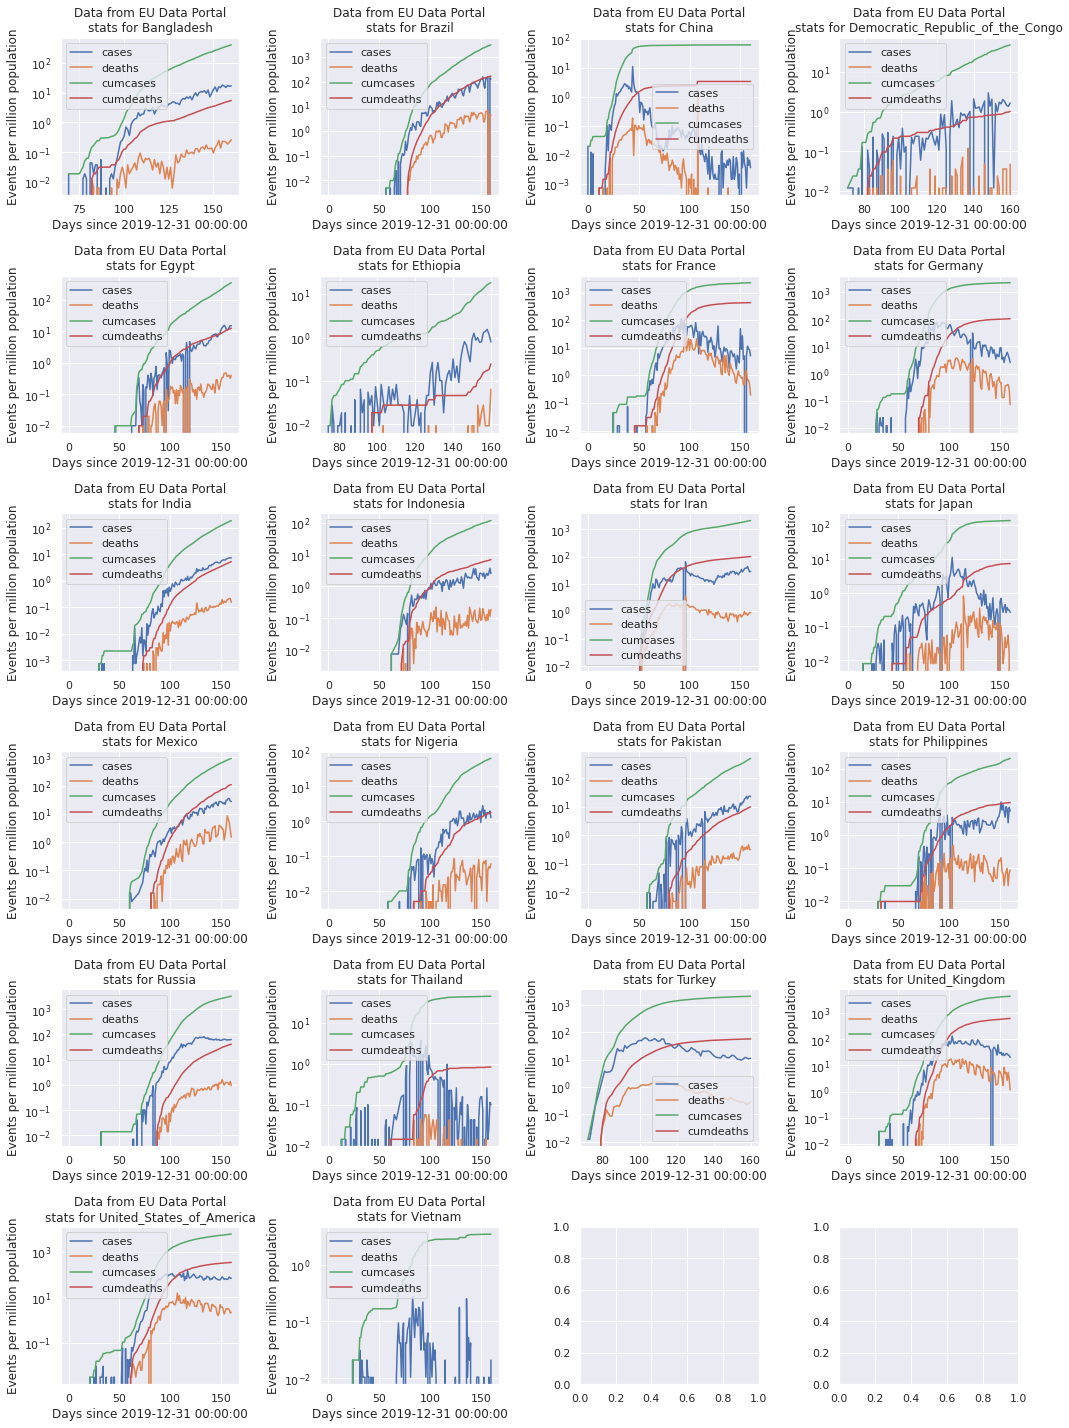

In [30]:
painter = figureFromFrame(None,  subplots=subnodeSpec, figsize=(15,20))
for (country,dfExtractOrig) in dtg :
    pop = dfExtractOrig["popData2018"][0]
    print(f"Country={country}, pop:{pop/1.0E6}M")
    dfExtract = dfExtractOrig.set_index("elapsedDays").copy()
    dfExtract.loc[:,"cumcases"] = dfExtract.loc[:,"cases"].sort_index().cumsum()/dfExtract.loc[:,"popData2018"]*1.0E6
    dfExtract.loc[:,"cumdeaths"] = dfExtract.loc[:,"deaths"].sort_index().cumsum()/dfExtract.loc[:,"popData2018"]*1.0E6
    dfExtract.loc[:,"cases"] = dfExtract.loc[:,"cases"]/dfExtract.loc[:,"popData2018"]*1.0E6
    dfExtract.loc[:,"deaths"] = dfExtract.loc[:,"deaths"]/dfExtract.loc[:,"popData2018"]*1.0E6
    painter.doPlot( df = dfExtract.loc[:,["cases","deaths","cumcases","cumdeaths"]],
                      colOpts={"cases": {"yscale":'log'},
                            "deaths": {"yscale":'log'},
                            "cumcases": {"yscale":'log'},
                            "cumdeaths": {"yscale":'log'},})
    painter.setAttrs(label=f"Days since {dateStart}",
                 title=f"Data from EU Data Portal\nstats for {country}",
                 legend=True,
                 xlabel=f"Days since {dateStart}",
                 ylabel="Events per million population"   )
    painter.advancePlotIndex()
ImgMgr.save_fig("FIG010")        